![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Create timeseries plots of fluxes and and storage for dedicated basins

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import os
import geopandas as gpd
import pandas as pd

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geoslurp import GeoslurpManager
from geoslurp.tools.xarray import *
import geoslurp.tools.pandas
import matplotlib as mpl
from scipy.integrate import cumulative_trapezoid


#local python tools
from common.config import *

In [75]:
conf=read_config()
datadir=conf['dataroot']
mediadir=conf['mediaroot']

In [81]:
#load TWS storage and flux data
dstws=xr.open_dataset(os.path.join(datadir,'dsdtbasav.nc')).rename(name='basin')


#load the ERA5 P,ET data
# dsera5=xr.open_dataset(os.path.join(datadir,'precip_evap_flux_monthly.nc'))
dsera5=xr.open_dataset(os.path.join(datadir,'prec_evap_flux.nc')).rename(valid_time='time')
display(dsera5)

<xarray.Dataset> Size: 550kB
Dimensions:     (time: 264, basin: 124)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2025-03-01T...
    expver      (time) <U4 4kB ...
  * basin       (basin) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
    basin_area  (basin) float64 992B ...
Data variables:
    avg_ie      (basin, time) float64 262kB ...
    avg_tprate  (basin, time) float64 262kB ...

In [128]:
# also cumulative integrate fluxes
dapet=dsera5.avg_ie+dsera5.avg_tprate
dapet=dapet-dapet.mean('time')
deltat=(dsera5.time-dsera5.time[0]).astype('timedelta64[s]').astype(int)
dsera5['pet_cuma']=(['basin','time'],cumulative_trapezoid(y=dapet.data,x=deltat,initial=0))

<xarray.Dataset> Size: 812kB
Dimensions:     (time: 264, basin: 124)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2025-03-01T...
    expver      (time) <U4 4kB ...
  * basin       (basin) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
    basin_area  (basin) float64 992B ...
Data variables:
    avg_ie      (basin, time) float64 262kB ...
    avg_tprate  (basin, time) float64 262kB ...
    pet_cuma    (basin, time) float64 262kB 0.0 -3.412e+09 ... 1.069e+12

In [90]:
dsera5.sel(basin='RHINE').basin_area.item()

832972700000.0

# plotting function

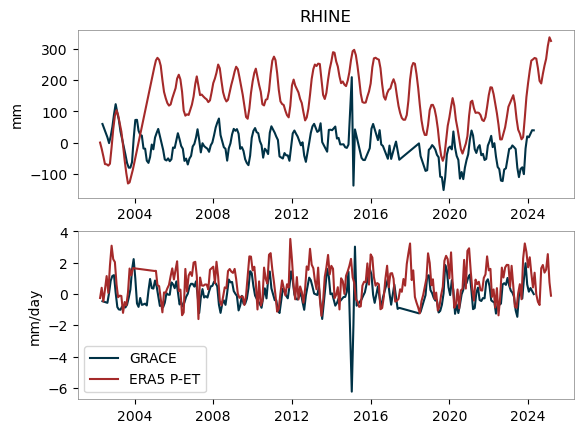

In [131]:

def make_plot(basin):
    f,(axstore,axflux)=plt.subplots(2,1)
    #basin selection
    tws=dstws.sel(basin=basin)
    era5=dsera5.sel(basin=basin)
    area=era5.basin_area.item()
    
    storescale=1e3
    storescale_era5=1e3/area
    axstore.plot(tws.time,storescale*tws.tws_ddk5_vw2016,color=posterdark,label='ERA5 P-ET')
    axstore.plot(era5.time,storescale_era5*(era5.pet_cuma),color=posterred,label='GRACE')
    axstore.set_ylabel('mm')
    axstore.set_title(f'{basin}')
    
    fluxscale_grc=86400*1e3
    fluxscale_era5=86400*1e3/area
    axflux.plot(tws.time,fluxscale_grc*tws.difft_vw2016,color=posterdark,label='GRACE')
    axflux.plot(era5.time,fluxscale_era5*(era5.avg_tprate+era5.avg_ie),color=posterred,label='ERA5 P-ET')
    axflux.set_ylabel('mm/day')
    plt.legend()
    plt.show()

make_plot(basin='RHINE')